<a href="https://colab.research.google.com/github/trtrgfh/caUzTjMHSKSQTVRu/blob/main/MonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# !unzip /content/gdrive/MyDrive/images.zip
# !rm -rf <folder_name>

# Prepare Data

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

In [4]:
torch.manual_seed(1234)
transform = transforms.Compose([
  transforms.Resize((224, 224)),  # Resize the image to a desired size
  transforms.ToTensor(),  # Convert the image to a tensor
  # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [5]:
# Load the images from the folders and create the dataset
def load_images_from_folder(folder, label):
  images = []
  for filename in os.listdir(folder):
    if filename.endswith(".jpg"):
      file_path = os.path.join(folder, filename)
      image = Image.open(file_path).convert("RGB")
      images.append(transform(image))
  labels = [label] * len(images)
  return images, labels

In [6]:
# Get training data
train_flip, train_flip_labels = load_images_from_folder("/content/images/training/flip", 1)
train_non_flip, train_non_flip_labels = load_images_from_folder("/content/images/training/notflip", 0)

train_images = train_flip + train_non_flip
train_labels = train_flip_labels + train_non_flip_labels

# Get testing data
test_flip, test_flip_labels = load_images_from_folder("/content/images/testing/flip", 1)
test_non_flip, test_non_flip_labels = load_images_from_folder("/content/images/testing/notflip", 0)

test_images = test_flip + test_non_flip
test_labels = test_flip_labels + test_non_flip_labels

In [7]:
print(f"number of training images:", len(train_images))
print(f"training images shape:", train_images[0].shape)
print(f"number of testing images:", len(test_images))
print(f"testing images shape:", test_images[0].shape)

number of training images: 2392
training images shape: torch.Size([3, 224, 224])
number of testing images: 597
testing images shape: torch.Size([3, 224, 224])


In [8]:
# m = # of examples, train_data[m][0] is the features, train_data[m][1] is the labels
train_data = torch.utils.data.TensorDataset(torch.stack(train_images), torch.LongTensor(train_labels))
test_data = torch.utils.data.TensorDataset(torch.stack(test_images), torch.LongTensor(test_labels))
batch_size = 32

# Create a DataLoader to load the data in batches for training
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a testing DataLoader, no need to shuffle for testing
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
# # Define the CNN model
# model = nn.Sequential(
#     nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Flatten(),
#     nn.Linear(16 * 112 * 112, 64),
#     nn.ReLU(),
#     nn.Linear(64, 2)
# )
# Define the CNN model
# "SAME" padding = ceil((f - 1) / 2)
model = nn.Sequential(
  nn.Conv2d(3, 8, kernel_size=4, stride=1, padding=2),
  nn.ReLU(),
  nn.MaxPool2d(kernel_size=8, stride=8, padding=4),
  nn.Conv2d(8, 16, kernel_size=2, stride=1, padding=1),
  nn.ReLU(),
  nn.MaxPool2d(kernel_size=4, stride=4, padding=2),
  nn.Flatten(),
  nn.Linear(16 * 8 * 8, 6),
  nn.Softmax(dim=1)
)

In [10]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
torch.manual_seed(1234)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)

for epoch in range(num_epochs):
  # Training
  train_loss = 0
  for images, labels in train_dataloader:
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)

    # Calculate loss
    loss = loss_fn(outputs, labels)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  final_y_pred = []
  model.eval()
  with torch.inference_mode():
    for images, labels in test_dataloader:
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)

      # Calculate loss
      loss = loss_fn(outputs, labels)
      test_loss += loss
      test_acc += (torch.eq(labels, outputs.argmax(dim=1)).sum().item() / len(outputs)) * 100

      final_y_pred.extend(outputs.argmax(dim=1).cpu().numpy())
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    f1 = f1_score(test_labels, final_y_pred)

  print(f"Epoch: {epoch+1}")
  print(f"Train_loss: {train_loss}, Test_loss: {test_loss}, Test_acc: {test_acc}, f1: {f1}")

Epoch: 1
Train_loss: 1.505711317062378, Test_loss: 1.4651633501052856, Test_acc: 54.06484962406015, f1: 0.5472636815920398
Epoch: 2
Train_loss: 1.4348623752593994, Test_loss: 1.3970682621002197, Test_acc: 67.81798245614036, f1: 0.6546762589928058
Epoch: 3
Train_loss: 1.3755847215652466, Test_loss: 1.340384840965271, Test_acc: 74.80419799498748, f1: 0.764612954186414
Epoch: 4
Train_loss: 1.3064571619033813, Test_loss: 1.2521140575408936, Test_acc: 84.11654135338347, f1: 0.8197343453510435
Epoch: 5
Train_loss: 1.2475700378417969, Test_loss: 1.2315587997436523, Test_acc: 84.84492481203007, f1: 0.8589540412044373
Epoch: 6
Train_loss: 1.195766806602478, Test_loss: 1.1977566480636597, Test_acc: 87.97775689223057, f1: 0.8852988691437803
Epoch: 7
Train_loss: 1.1720424890518188, Test_loss: 1.1706502437591553, Test_acc: 87.90726817042606, f1: 0.8625235404896423
Epoch: 8
Train_loss: 1.1553418636322021, Test_loss: 1.2690467834472656, Test_acc: 77.05200501253132, f1: 0.6876404494382022
Epoch: 9
Tra

In [12]:
mismatched_indices = np.where(np.array(final_y_pred) != np.array(test_labels))[0]

In [13]:
random_mismatched = np.random.choice(mismatched_indices, size=10, replace=False)

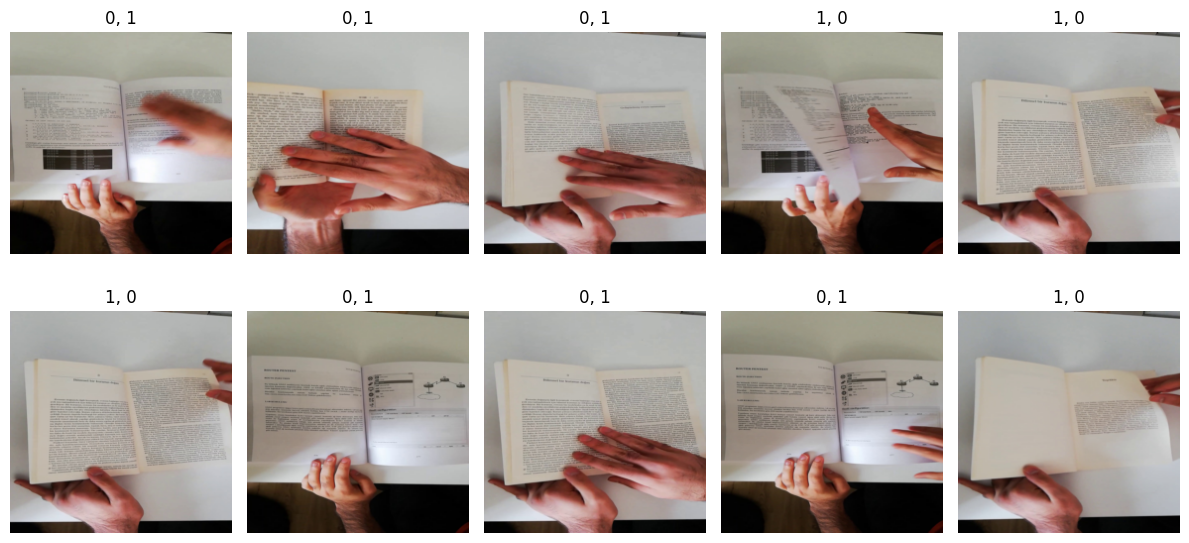

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Assuming test_images is a list of tensor images
for i, index in enumerate(random_mismatched):
    image = test_images[index]

    # Convert tensor to NumPy array
    np_image = image.numpy()

    # Transpose dimensions to (height, width, channels)
    np_image = np.transpose(np_image, (1, 2, 0))

    # Plot the image in the current subplot
    ax = axs[i // 5, i % 5]
    ax.imshow(np_image)
    ax.axis('off')

    # Set the label on top of the image
    ax.set_title(f"{test_labels[index]}, {final_y_pred[index]}")

plt.tight_layout()
plt.show()